In [1]:
import gym
import matplotlib.pyplot as plt
import random
import numpy as np
from gridworld.gridworld import GridWorldEnvNew
import argparse

env = gym.make('MyGridworld-v2')
store_state = {}
store_action = {}
store_reward = {}
store_qfunc = {}
total_reward = []

a_seed = 543
a_render = True 
a_gamma = 1
a_log_interval = 10
a_lr = 1e-2

env.seed(a_seed)

[543]

In [2]:
def compute_gradient(policy, state, action):
    
    delt_grad = np.zeros(policy.shape)
    
    ### softmax layer 
    pmf_smax = np.exp(policy[state,:]) / np.sum(np.exp(policy[state,:]), axis=0)

    ### Finding Delta_grad-> \delta_{ss} and \delta_{aa}
    delt_grad[state,:] = -pmf_smax[action]
    delt_grad[state,action] = 1 - pmf_smax[action]
    
    return delt_grad, np.log(pmf_smax[action])

In [10]:
def REINFORCE_learning(no_episodes, episode_len,batch_size, alpha, baseline_length, algo = 'd'): 
    no_batch = int(no_episodes/batch_size)
    pfunc = np.zeros([env.observation_space.n, env.action_space.n])
    rf_reward = []

    store_all_rewards = []
    store_all_grads = []
    for i_batch in range(no_batch): 
        delt_grad = np.zeros(pfunc.shape)
        reward_batch = 0
    
        for n_bach in range(batch_size):
            ### Initialize the episode with random state
            init_state, cur_pos = env.reset()
            #print('Reset state: ', init_state)
    
            store_s = np.zeros([episode_len], dtype=int) #store states
            store_a = np.zeros([episode_len], dtype=int) # store actions
            store_r = np.zeros([episode_len], dtype=int) # store rewards
            store_p = np.zeros([episode_len], dtype=int) ## log probabilities
            
            for t in range(episode_len):        
        
                ### policy based action gradient
                pmf_smax = np.exp(pfunc[cur_pos,:]) / np.sum(np.exp(pfunc[cur_pos,:]), axis=0)
                a = np.random.choice(np.arange(pfunc.shape[1]), 1, replace=False, p=pmf_smax)
                action =  int(a) 
                store_a[t] = action
                store_p[t] = np.log(pmf_smax[a])
                
                ### Environment is propagated based on action taken
                next_state, reward, done, info = env.step(action)
                next_pos = info['pos'] ## S'
        
                ### Plotting and Storing
                #print(" ")
                #print("Action: ", action)     
                #print("Reward: ", reward)
                #print("State:  ", next_pos, next_state)
                store_s[t] = next_pos
                store_r[t] = reward
            
                cur_pos = next_pos ## S<--S
                env.render()
    
            ### Calculating the baselines
            if (algo.find('b')!=-1):
                store_all_rewards.append(store_r)
            
                ### Calculating baseline information from rewards
                ### Ask Dr. West or Dr. Bretl if this makes sense? 
                store_b = np.zeros([episode_len])
                if (i_batch+n_bach >=baseline_length):
                    for j in range(i_batch+n_bach-baseline_length, i_batch+n_bach):
                        for t in range(episode_len):
                            store_b[t] += np.sum(store_all_rewards[j][t:])
                    store_b = store_b/float(baseline_length)
                    #print('baseline: ', store_b, float(i_batch+n_bach+1))
            
            #### Here update the policy based on the episode states, actions and rewards
            grad_eps = np.zeros(pfunc.shape)
            reward_eps = 0
            for t in range(episode_len):
                ## checking for causality 
                reward_c, reward_b, likeli_i = 0, 0, 0
                if (algo.find('c')!=-1):
                    reward_c = np.sum(store_r[t:])
                else: 
                    reward_c = np.sum(store_r)
                ## checking for baseline
                if (algo.find('b')!=-1):
                    reward_b = reward_c - store_b[t]
                else: 
                    reward_b = reward_c

                #update the gradient
                grad_val, new_lh = compute_gradient(pfunc, store_s[t], store_a[t])
                grad_eps += reward_b*grad_val
                reward_eps += store_r[t]
                
                ## checking for baseline
                #if (algo.find('i')!=-1):
                #    likeli_i = 1 #reward_c - bline[t]
                #else: 
                #    likeli_i = 1

            old_lh = np.sum(store_p)
            if (algo.find('i')!=-1):
                imp_samp_lh = np.exp(old_lh) / np.exp(new_lh)
            else: 
                imp_samp_lh = 1.0
            delt_grad += (imp_samp_lh * grad_eps) / batch_size
            reward_batch += reward_eps / batch_size
        
        #update policy
        rf_reward.append(reward_batch)
        pfunc = pfunc + alpha * delt_grad

    env.close()
    
    return pfunc, rf_reward

In [4]:
## With first st of hyperparameters
no_episodes = 200 #0
episode_len = 100 
batch_size = 10
alpha = 0.05
baseline_length = 5

## these results are shown for easy level
bci_pfunc, bci_reward = REINFORCE_learning(no_episodes, episode_len,batch_size, alpha, baseline_length, algo='bci')

In [11]:
### This one is for the old reinforcement learning implemented in last week homework
d_pfunc, d_reward = REINFORCE_learning(no_episodes, episode_len,batch_size, alpha, baseline_length, algo='d')

/home/green/workspace_ae598rl/lib/python3.5/site-packages/matplotlib/legend.py:937: UserWarning: Legend does not support 'o' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/home/green/workspace_ae598rl/lib/python3.5/site-packages/matplotlib/legend.py:937: UserWarning: Legend does not support 'l' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/home/green/workspace_ae598rl/lib/python3.5/site-packages/matplotlib/legend.py:937: UserWarning: Legend does not support 'd' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format

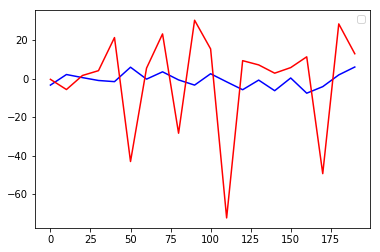

In [12]:
plt.plot(np.arange(int(no_episodes/batch_size))*batch_size, bci_reward, 'b')
plt.plot(np.arange(int(no_episodes/batch_size))*batch_size, d_reward, 'r')
plt.legend('old REINFORCE', 'new REINFORCE')
plt.show()

In [ ]:
## With second set of hyperparameters
no_episodes = 200
episode_len = 50  
batch_size = 20
alpha = 0.1

### these results are shown for easy level
bc_pfunc, bc_reward = REINFORCE_learning(no_episodes, episode_len,batch_size, alpha, baseline_length)
bi_pfunc, bi_reward = REINFORCE_learning(no_episodes, episode_len,batch_size, alpha, baseline_length)
ci_pfunc, ci_reward = REINFORCE_learning(no_episodes, episode_len,batch_size, alpha, baseline_length)

In [ ]:
plt.plot(np.arange(int(no_episodes/batch_size))*batch_size, bc_reward, 'b')
plt.plot(np.arange(int(no_episodes/batch_size))*batch_size, bi_reward, 'r')
plt.plot(np.arange(int(no_episodes/batch_size))*batch_size, ci_reward, 'k')
plt.legend('no imp_samp', 'no_causality', 'no baseline')
plt.show()